In [1]:
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

def center_window_sum(a, snp, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(a[snp][start:end])
    return score

def calc_bis_score(a, win):
    #return max_sub_array_sum(a, size)
    win_sums = []
    for snp in range(len(a)):
        win_sum = center_window_sum(a, snp, win)
        win_sums.append(win_sum)
    return win_sums

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = calc_bis_score(snp_diffs[i], 11)
    # elementwise max among 3 lists
    max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    lines     = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            lines.append(line)
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals, lines

('snp_orig shape=', (1000, 4), 20000)
('snp_diff 1 shape=', (1000, 4))
('snp_diff 2 shape=', (1000, 4))
('snp_diff 3 shape=', (1000, 4))


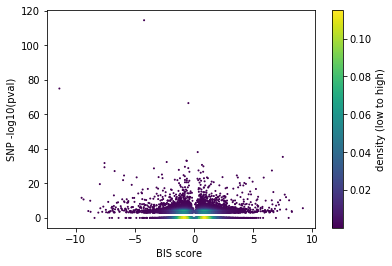

<Figure size 432x288 with 0 Axes>

In [2]:
#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
bis_scores = get_bis_scores(snp_diffs)



#snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
snp_dir  = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
#snp_file = "RELA_10k.txt"
snp_file = "RELA_20k.txt"

snp_pvals, lines = get_snp_pvals(snp_dir + snp_file)

#print(len(snp_pvals))
#print(len(bis_scores))

#%matplotlib inline
tf = 'RELA'

%matplotlib inline
import matplotlib as mpl
#mpl.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)

x=bis_scores[:]
y=snp_pvals[:]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("BIS score ")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
plt.savefig("deeplift_score_vs_pval.png")    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

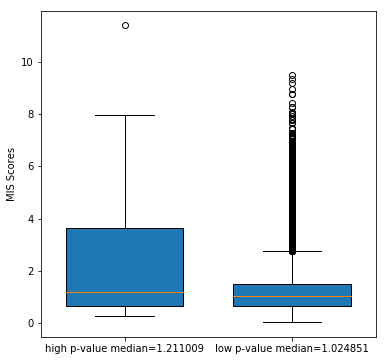

In [6]:
fig = plt.figure(1, figsize=(6, 6))

limit = 100
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[limit:]]
data_to_plot = [hi, lo]
median_hi = np.median(hi)
median_lo = np.median(lo)
xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]

bp = plt.boxplot(data_to_plot, labels=xlabels, widths=0.7, patch_artist=True)
plt.ylabel("MIS Scores")
plt.show()


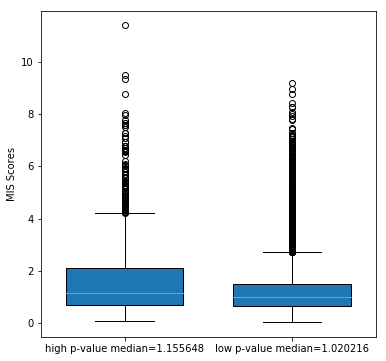

In [8]:
fig = plt.figure(1, figsize=(6, 6))

limit = 1000
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[limit:]]
data_to_plot = [hi, lo]
median_hi = np.median(hi)
median_lo = np.median(lo)
xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]

bp = plt.boxplot(data_to_plot, labels=xlabels, widths=0.7, patch_artist=True)
plt.ylabel("MIS Scores")
plt.show()


-----
scores/interpret.fa0
(20000, 1000, 4)
[[ 0.09928025  0.20510769  0.13387954 -0.07191937]
 [-0.06391124  0.29272422 -0.09958851  0.05923964]
 [ 0.03352506  0.00290122  0.01548704 -0.19224617]
 [ 0.01050163 -0.04247808  0.09540421 -0.07524462]
 [-0.05391943  0.11075372  0.25955582 -0.03856779]
 [ 0.03081908  0.09580111  0.24597563 -0.05163607]
 [-0.06963163  0.26825106 -0.07649054 -0.14147402]
 [-0.15626599  0.01617742 -0.02153429  0.05013984]
 [-0.06743986 -0.1077885   0.10109053  0.05560966]
 [-0.16954985  0.00433816  0.13624012 -0.2582909 ]]
-----
0 chr11:30344883 G->C score=-4.22385 loss
1 chr3:192616700 T->G score=-11.38325 loss
2 chr1:149577335 G->C score=-0.47952 gain
3 chr1:145209819 C->T score=0.30765 loss
('TCCGCGTTTC[C]TGGGGTCGA', 'importance score for original sequence')


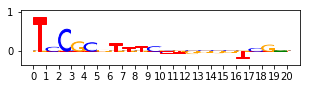

('TCCGCGTTTC[T]TGGGGTCGA', 'importance score for mutated sequence ')


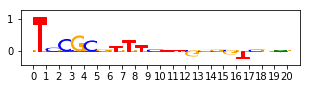

Mutation Impact Score 


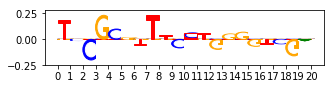

4 chr4:133045472 C->A score=7.50044 gain
5 chr7:100230864 G->C score=-0.64271 loss
6 chr1:144932151 G->T score=-0.61457 loss
7 chr4:4027574 T->C score=-2.31363 loss
8 chr6:26464472 C->T score=-7.56951 loss
9 chr17:80802744 A->C score=0.67026 gain
10 chr8:12052475 G->C score=0.79114 gain
11 chr7:303680 A->G score=-0.77324 gain
12 chr3:119999621 T->G score=-7.57223 loss
13 chr3:192616614 C->T score=-0.48912 loss
('taggctggcc[c]aaaaggcct', 'importance score for original sequence')


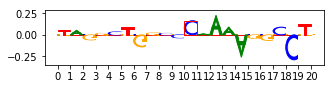

('TAGGCTGGCC[T]AAAAGGCCT', 'importance score for mutated sequence ')


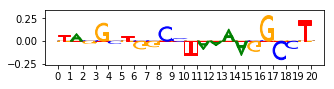

Mutation Impact Score 


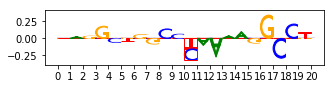

14 chr19:8552167 C->T score=-3.39154 loss
15 chr7:102305523 C->T score=-1.28756 loss
16 chr7:93221402 C->G score=0.37698 loss
('TCATATTGAC[C]TTTGATGGT', 'importance score for original sequence')


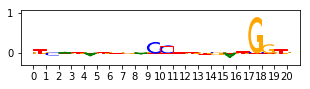

('TCATATTGAC[G]TTTGATGGT', 'importance score for mutated sequence ')


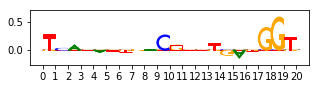

Mutation Impact Score 


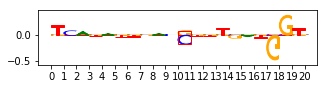

17 chr15:31115853 G->T score=6.57999 gain
18 chr19:50420671 C->A score=-6.71518 loss
19 chr6:26660655 G->C score=0.77017 loss
20 chr17:80802698 A->G score=-0.39317 gain
21 chr20:61490196 C->T score=0.56238 gain
22 chr1:40241946 G->A score=-2.71645 loss
23 chr17:1388656 G->T score=-0.88416 loss
24 chr13:45097971 C->T score=3.61485 gain
25 chr1:28572207 C->T score=-5.91735 loss
26 chr9:107690535 G->C score=-0.78351 gain
27 chr2:232526743 G->C score=-2.99707 loss
28 chr9:69804883 T->G score=2.40526 gain
29 chr1:144534083 C->T score=-4.85358 loss
30 chr6:28867915 C->G score=1.09251 loss
31 chr8:3982275 G->A score=3.69837 gain
32 chr14:33075706 T->C score=5.88739 gain
33 chr2:46033907 G->A score=4.68056 gain
34 chr2:232526746 A->G score=-2.66588 loss
35 chr8:110064864 A->G score=1.16860 loss
36 chr14:24476433 C->G score=0.83705 gain
37 chr13:66797237 A->G score=-1.19086 gain
38 chr21:45377650 G->A score=-0.60933 loss
39 chr10:28691869 C->A score=0.28833 loss
('ctcactatca[c]gagaacagc', 'impo

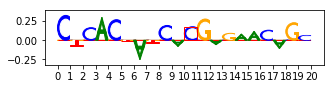

('CTCACTATCA[A]GAGAACAGC', 'importance score for mutated sequence ')


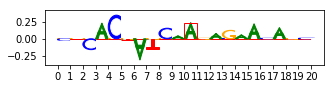

Mutation Impact Score 


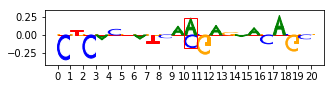

40 chr9:100273390 A->G score=0.48516 loss
('acacacacac[a]cacaGGCTT', 'importance score for original sequence')


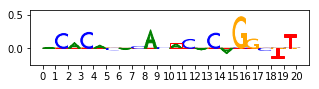

('ACACACACAC[G]CACAGGCTT', 'importance score for mutated sequence ')


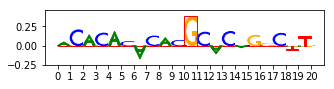

Mutation Impact Score 


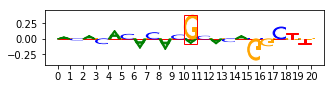

41 chr19:2598515 T->C score=-1.62798 gain
42 chr9:70646472 G->A score=-0.76990 gain
43 chr19:52133734 G->A score=-5.99973 loss
44 chr12:96710205 C->G score=-1.40782 gain
45 chr19:2598511 T->C score=0.35578 loss
('aaaaattagc[t]gggtgtggt', 'importance score for original sequence')


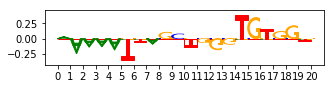

('AAAAATTAGC[C]GGGTGTGGT', 'importance score for mutated sequence ')


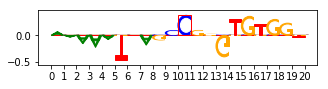

Mutation Impact Score 


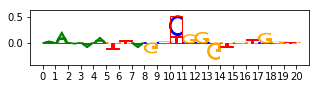

46 chr16:21513372 T->C score=-0.61521 gain
47 chr6:26305407 G->C score=0.59264 gain
48 chr15:100346577 G->A score=-0.39674 loss
('tttttagtgg[g]gacggggtt', 'importance score for original sequence')


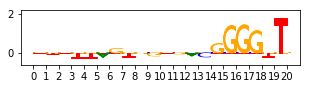

('TTTTTAGTGG[A]GACGGGGTT', 'importance score for mutated sequence ')


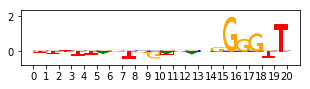

Mutation Impact Score 


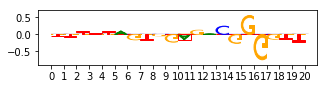

49 chr4:4030813 C->T score=0.88917 loss
50 chr17:38350730 C->G score=1.48844 gain
51 chr13:32012180 T->G score=4.94966 gain
52 chr2:223885180 A->G score=1.66141 gain
53 chr15:70789797 T->A score=-0.76838 gain
54 chr18:5254130 A->T score=-0.62538 gain
55 chr6:26087202 G->C score=-0.49126 loss
('GGCTGTGGAA[G]GTGTTTCAG', 'importance score for original sequence')


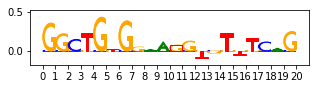

('GGCTGTGGAA[C]GTGTTTCAG', 'importance score for mutated sequence ')


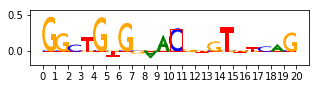

Mutation Impact Score 


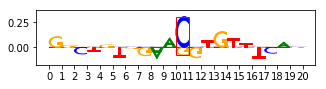

56 chr11:30344799 A->G score=0.46496 gain
57 chr8:66988315 T->C score=4.25101 loss
58 chr3:52890966 A->G score=3.86319 gain
59 chr4:75962642 A->G score=-1.26994 gain
60 chr19:1884598 G->C score=4.38132 gain
61 chr12:6561145 G->A score=-7.96327 loss
62 chr6:2872920 A->G score=1.42587 loss
63 chr6:43192269 T->G score=-5.27125 loss
64 chr7:5608932 G->C score=0.55532 gain
65 chr5:64064590 G->A score=-1.17132 loss
66 chr15:96632825 G->C score=3.90447 gain
67 chr18:5254081 C->T score=2.13936 gain
68 chr14:107183254 T->C score=0.94267 loss
69 chr6:166913345 G->C score=4.16483 gain
70 chr14:107183242 A->C score=-0.43275 loss
('ACAATGAGGC[A]GCCCCAGAC', 'importance score for original sequence')


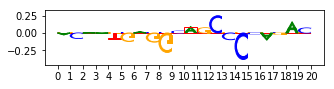

('ACAATGAGGC[C]GCCCCAGAC', 'importance score for mutated sequence ')


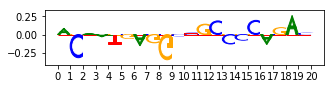

Mutation Impact Score 


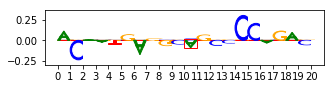

71 chr3:46773510 G->T score=1.30121 gain
72 chr15:22571289 G->A score=-1.11991 loss
73 chr14:107183253 A->G score=1.22648 loss
74 chr2:114361603 A->C score=-0.76463 gain
75 chr12:3853196 T->A score=0.84529 gain
76 chr16:15068908 C->G score=-0.52815 loss
77 chr11:69029210 A->C score=3.72766 gain
78 chr9:132681784 T->C score=-3.17082 loss
79 chr9:131456520 T->G score=-0.96730 gain
80 chr13:32012144 C->T score=1.19554 gain
81 chr11:67698050 G->A score=0.82126 loss
82 chr20:17629694 C->T score=2.78712 gain
83 chr4:86478381 T->C score=0.39745 loss
('agtggaggca[t]ggcttgcag', 'importance score for original sequence')


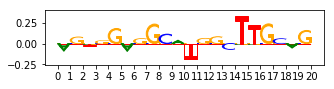

('AGTGGAGGCA[C]GGCTTGCAG', 'importance score for mutated sequence ')


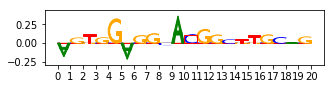

Mutation Impact Score 


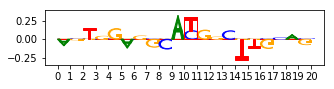

84 chr4:40307564 C->T score=-2.50376 loss
85 chr13:66797272 G->C score=2.66595 gain
86 chr14:63945298 G->C score=0.49200 loss
('gcagattctg[g]aaaacacgg', 'importance score for original sequence')


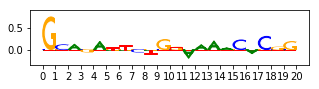

('GCAGATTCTG[C]AAAACACGG', 'importance score for mutated sequence ')


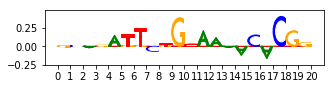

Mutation Impact Score 


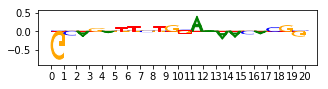

87 chr1:154359411 G->A score=3.31808 loss
88 chr18:11293981 T->C score=-3.04165 loss
89 chr3:15680525 G->A score=-3.90819 loss
90 chr3:138920886 T->C score=5.23004 gain
91 chr8:118991042 A->G score=0.38111 gain
92 chr1:25360703 A->C score=0.62223 loss
93 chr21:30476586 G->A score=-1.94944 loss
94 chr3:57945768 T->C score=-4.34533 gain
95 chr7:95023804 G->C score=-0.68729 loss
96 chr1:144521492 G->T score=-0.89359 loss
97 chr21:45579901 A->G score=-1.88703 loss
98 chr5:14744551 C->G score=-0.96457 loss
99 chr21:10997800 C->A score=-0.87654 loss
('max_mis_score=\n', [-4.2238545, -11.383252, -0.4795241, 0.30765018, 7.500438])


In [7]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
seqs        = {}
snp_orig, orig_seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [0,2,0] # A->G(1), C->A(0), C->T(2)

snp_desc   = ["SNP chr4:176935913 C->A", "SNP chr12:16789835 C->T", "SNP chr12:8608502 T->A"]

def seqs_str(seqs, snp):
    return seqs[snp][490:500] + '[' + seqs[snp][500:501] + ']' + seqs[snp][501:510]

thresh = 0.5

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))

for i in range(3): # each i is an allele
    snp_alleles[i], seqs[i]  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

for snp in range(100):

    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    line = lines[snp]
    fields = line.split('\t')
    alt_depth = int(fields[3])
    ref_depth = int(fields[4])
    print("%d %s:%s %s->%s score=%.5f %s" % (snp, fields[0], fields[1], fields[6], fields[5], x[snp], 
          "gain" if alt_depth > ref_depth else "loss"))

    if not (abs(x[snp]) > thresh or alt_depth > ref_depth):
        print(seqs_str(orig_seqs, snp), "importance score for original sequence")
        viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}

    for i in range(3): # each i is an allele
        snp_allele = snp_alleles[i]
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if abs(x[snp]) > thresh or alt_depth > ref_depth:
            continue
        if fields[5] == seqs[i][snp][500]:
        #if i == allele_idx[snp]:

            print(seqs_str(seqs[i], snp), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
'''
for i in range(3):
    snp_diff = snp_diffs[i]
    print("allele", i)
    print(snp_diff[snp][499:502])

    win = 3
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(snp_diff[snp][start:end])
    print(start, end, score)
    
    win_sums = center_window_sum(snp_diff, snp, 3)
    print("winsums=", win_sums)
    bis_scores[i] = calc_bis_score(snp_diffs[i], 3)
    # elementwise max among 3 lists
    print("bis_scores for allele", i, bis_scores[i])

max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
print("max_bis_score=\n", max_bis_score[:5])
'''

max_bis_score = get_bis_scores(snp_diffs)
print("max_mis_score=\n", max_bis_score[:5])
